## Applying the bias scan tool on a BERT disinformation classifier
In this notebook, the bias scan tool is applied on a BERT-based disinformation classifier. The bias scan tool is based on an implementation of the k-means Hierarchical Bias Aware Clustering (HBAC) method\*. The python script `./helper_functions.py` contains functions that execute the bias scan. A conceptual description how the bias scan works, including the rationale why k-means is chosen as a clustering algorithm and paramater choices, can be found in the [bias scan tool report](https://github.com/NGO-Algorithm-Audit/Bias_scan/blob/master/Bias_scan_tool_report.pdf).

The classifier is used to make predictions on the Twitter15-16\*\* data set. Details on pre-processing steps performed on this dataset are provided in the `../data/Twitter_dataset/Twitter1516_preprocessing.ipynb` notebook. Details on training the BERT disinformation classifier is provided in the `../case_studies/BERT_disinformation_classifier/BERT_Twitter_classifier.ipynb` notebook.

\* Misztal-Radecka, Indurkya, *Information Processing and Management*. Bias-Aware Hierarchical Clustering for detecting the discriminated groups of users in recommendation systems (2021).

\*\* Liu, Xiaomo and Nourbakhsh, Armineh and Li, Quanzhi and Fang, Rui and Shah, Sameena, *Proceedings of the 24th ACM International on Conference on Information and Knowledge Management* (2015) [[link to dataset]](https://www.dropbox.com/s/7ewzdrbelpmrnxu/rumdetect2017.zip?dl=0&file_subpath=%2Frumor_detection_acl2017)

### Overview of notebook:
1. Load data and pre-processing
2. Bias scan using the k-means HBAC algorithm
    - False Positive Rate (FPR) as bias metric
    - False Negative Rate (FNR) as bias metric    
3. Clustering results
4. Statistical testing of inter-cluster difference 

### Load libraries

In [1]:
import sys  
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns

# IPython
from IPython.display import Markdown, display

# matplotlib
import matplotlib.pyplot as plt

# helper functions
sys.path.insert(1, './../')
from helper_functions import *

warnings.filterwarnings('ignore')

### 1. Load data and pre-processing

In [2]:
# read data
path = './../../classifiers/BERT_disinformation_classifier/pred_BERT.csv'
df_pred = pd.read_csv(path)

# change column names
df_pred.columns = ['tweet','predicted_class','true_class']

# Calculating absolute errors
df_pred['errors'] = abs(df_pred['predicted_class'] - df_pred['true_class'])

# Calculate FP errors
FP_condition = (df_pred['predicted_class'] == 1) & (df_pred['true_class'] == 0)
df_pred['FP_errors'] = np.where(FP_condition, 1, 0)

# Calculate FN errors
FN_condition = (df_pred['predicted_class'] == 0) & (df_pred['true_class'] == 1)
df_pred['FN_errors'] = np.where(FN_condition, 1, 0)

df_pred.head()

,tweet,predicted_class,true_class,errors,FP_errors,FN_errors
0,"it was a long, dark day in ottawa. a timeline ...",0,0,0,0,0
1,hewlett-packard will split into two companies ...,0,0,0,0,0
2,white house lit in rainbow colors after high c...,0,0,0,0,0
3,breaking: 10 reportedly shot dead at paris hq ...,0,0,0,0,0
4,steve jobs was adopted. his biological father ...,1,1,0,0,0


In [3]:
df_pred.shape

(423, 6)

#### Add features to data

In [4]:
pwd

'/Users/jurriaan/Documents/Documents – privé/AlgorithmAudit/Bias_scan/HBAC_scan/Disfinformation'

In [5]:
path_feat = '../../data/Twitter_dataset/twitter1516_final.csv'
df_feat = pd.read_csv(path_feat)
df_feat.head(2)

,label,tweet_id,tweet,length,#URLs,#mentions,#hashs,verified,#followers,user_engagement,sentiment_score
0,1,489800427152879616,malaysia airlines says it lost contact with pl...,95,2,0,0,1,15375121,72.567469,-0.3182
1,1,560474897013415936,for just $1 you can get a free jr. frosty with...,118,1,1,0,1,3673898,55.294333,0.8398


#### Data cleaning

In [7]:
df_full = pd.merge(df_pred, df_feat, on=['tweet'])

# Drop duplicate rows in merged dataframe
df_full = df_full.drop_duplicates('tweet', keep='last')

# remove certain columns
df_full = df_full.drop(columns=['tweet','tweet_id','label'])

# features dataframe
features = df_full.drop(['predicted_class', 'true_class', 'errors', 'FP_errors', 'FN_errors'], axis=1)

df_full.head()

,predicted_class,true_class,errors,FP_errors,FN_errors,length,#URLs,#mentions,#hashs,verified,#followers,user_engagement,sentiment_score
0,0,0,0,0,0,84,2,0,1,1,1828600,102.622934,-0.4767
1,0,0,0,0,0,93,1,0,0,1,45988032,82.510668,0.0000
2,0,0,0,0,0,89,1,0,0,1,16023476,155.112226,0.0000
3,0,0,0,0,0,80,1,0,0,1,3629813,601.280035,-0.6486
35,1,1,0,0,0,87,0,0,0,0,3479057,253.795131,0.0000


In [8]:
df_full.shape

(413, 13)

In [10]:
df_test = df_full.drop(['errors', 'FP_errors', 'FN_errors'], axis=1)
df_test2 = df_test.rename({'predicted_class': 'pred_label', 'true_class': 'truth_label'}, axis=1) 
df_test2.head()

,pred_label,truth_label,length,#URLs,#mentions,#hashs,verified,#followers,user_engagement,sentiment_score
0,0,0,84,2,0,1,1,1828600,102.622934,-0.4767
1,0,0,93,1,0,0,1,45988032,82.510668,0.0000
2,0,0,89,1,0,0,1,16023476,155.112226,0.0000
3,0,0,80,1,0,0,1,3629813,601.280035,-0.6486
35,1,1,87,0,0,0,0,3479057,253.795131,0.0000


In [11]:
df_test2.to_csv('./test_pred_BERT.csv', index=False)

### Data initialization

In [12]:
full_data = init_dataset(df_full,features)
full_data.head()

,predicted_class,true_class,errors,FP_errors,FN_errors,length,#URLs,#mentions,#hashs,verified,#followers,user_engagement,sentiment_score,clusters,new_clusters
0,0,0,0,0,0,-0.341015,0.990826,-0.319494,0.628861,0.572690,-0.352927,0.548740,-0.626901,0,-1
1,0,0,0,0,0,0.056461,-0.445003,-0.319494,-0.596232,0.572690,3.792159,0.266703,0.481597,0,-1
2,0,0,0,0,0,-0.120195,-0.445003,-0.319494,-0.596232,0.572690,0.979494,1.284804,0.481597,0,-1
3,0,0,0,0,0,-0.517671,-0.445003,-0.319494,-0.596232,0.572690,-0.183854,7.541476,-1.026630,0,-1
35,1,1,0,0,0,-0.208523,-1.880832,-0.319494,-0.596232,-1.746144,-0.198005,2.668648,0.481597,0,-1


### 2. HBAC using k-means clustering

Clustering algorithms parameters:

In [13]:
clustering_paramaters = {
    "n_clusters": 2,
    "init": "k-means++",
    "n_init": 20,
    "max_iter": 300
}

Specify:
- Minimal splittable cluster size
- Minimal acceptable cluster size

In [14]:
# minimal splittable cluster size
split_cluster_size = round(0.07 * len(full_data))
print("minimal splittable cluster size: ", split_cluster_size)

# minimal acceptable cluster size
acc_cluster_size = round(0.05 * len(full_data))
print("minimal acceptable cluster size: ", acc_cluster_size)

minimal splittable cluster size:  29
minimal acceptable cluster size:  21


#### 2a. FP as bias metric
Performing bias scan using helper functions.

In [15]:
# HBAC clustering
df_FP = HBAC_bias_scan(full_data, 'FP', split_cluster_size, acc_cluster_size, clustering_paramaters)
df_FP.head()

bias FP is:  0.8862275449101796
done


,predicted_class,true_class,errors,FP_errors,FN_errors,length,#URLs,#mentions,#hashs,verified,#followers,user_engagement,sentiment_score,clusters,new_clusters
0,0,0,0,0,0,-0.341015,0.990826,-0.319494,0.628861,0.572690,-0.352927,0.548740,-0.626901,0,0.0
1,0,0,0,0,0,0.056461,-0.445003,-0.319494,-0.596232,0.572690,3.792159,0.266703,0.481597,0,1.0
2,0,0,0,0,0,-0.120195,-0.445003,-0.319494,-0.596232,0.572690,0.979494,1.284804,0.481597,0,0.0
3,0,0,0,0,0,-0.517671,-0.445003,-0.319494,-0.596232,0.572690,-0.183854,7.541476,-1.026630,0,0.0
35,1,1,0,0,0,-0.208523,-1.880832,-0.319494,-0.596232,-1.746144,-0.198005,2.668648,0.481597,1,-1.0


#### 2b. FN as bias metric
Performing bias scan using helper functions.

In [16]:
# HBAC clustering
df_FN = HBAC_bias_scan(full_data,'FN',split_cluster_size,acc_cluster_size, clustering_paramaters)
df_FN.head()

bias FN is:  0.7195121951219512
done


,predicted_class,true_class,errors,FP_errors,FN_errors,length,#URLs,#mentions,#hashs,verified,#followers,user_engagement,sentiment_score,clusters,new_clusters
0,0,0,0,0,0,-0.341015,0.990826,-0.319494,0.628861,0.572690,-0.352927,0.548740,-0.626901,0,-1.0
1,0,0,0,0,0,0.056461,-0.445003,-0.319494,-0.596232,0.572690,3.792159,0.266703,0.481597,0,-1.0
2,0,0,0,0,0,-0.120195,-0.445003,-0.319494,-0.596232,0.572690,0.979494,1.284804,0.481597,0,-1.0
3,0,0,0,0,0,-0.517671,-0.445003,-0.319494,-0.596232,0.572690,-0.183854,7.541476,-1.026630,0,-1.0
35,1,1,0,0,0,-0.208523,-1.880832,-0.319494,-0.596232,-1.746144,-0.198005,2.668648,0.481597,1,-1.0


### 3. Analysing clustering results
#### 3a. FP bias metric
Identifying cluster with most FPs.

In [17]:
c_FP = get_max_bias_cluster(df_FP, 'FP')
max_bias_FP = round(bias_acc(df_FP, 'FP', c_FP, "clusters"), 2)
highest_biased_cluster_FP = df_FP[df_FP['clusters']==c_FP]
print(f"cluster {c_FP} has the highest bias (FP): " + str(max_bias_FP))
print("#elements in highest biased cluster:", len(highest_biased_cluster_FP))

# discriminated cluster
discriminated_cluster_FP = full_data[full_data['clusters']==c_FP].drop(columns=['predicted_class', 'true_class', 'errors','clusters', 'new_clusters', 'FP_errors', 'FN_errors'])
not_discriminated_FP = full_data[full_data['clusters']!=c_FP].drop(columns=['predicted_class', 'true_class', 'errors','clusters', 'new_clusters', 'FP_errors', 'FN_errors'])

# index of discriminated cluster
FP_idx = discriminated_cluster_FP.index.tolist()

discriminated_cluster_FP.head()

0 has bias 0.08097165991902844
1 has bias 0.1225806451612903
4 has bias -0.1506622516556292
3 has bias -0.0888888888888888
2 has bias -0.06601650412603155
cluster 1 has the highest bias (FP): 0.12
#elements in highest biased cluster: 22


,length,#URLs,#mentions,#hashs,verified,#followers,user_engagement,sentiment_score
35,-0.208523,-1.880832,-0.319494,-0.596232,-1.746144,-0.198005,2.668648,0.481597
38,0.939742,-1.880832,-0.319494,-0.596232,-1.746144,-0.524223,0.197472,-1.026630
51,2.043842,-1.880832,-0.319494,-0.596232,-1.746144,-0.379147,-0.570188,1.416158
78,-0.473507,-1.880832,-0.319494,-0.596232,-1.746144,-0.442316,-0.857943,-1.101042
84,0.144790,-1.880832,-0.319494,-0.596232,-1.746144,-0.524526,-0.785319,-1.393339


#### 3b. FN as bias metric
Identifying cluster with most negative bias (FN).

In [18]:
c_FN = get_max_bias_cluster(df_FN, 'FN')
max_bias_FN = round(bias_acc(df_FN, 'FN', c_FN, "clusters"), 2)
highest_biased_cluster_FN = df_FN[df_FN['clusters']==c_FN]
print(f"cluster {c_FN} has the highest bias (FN): " + str(max_bias_FN))
print("#elements in highest biased cluster:", len(highest_biased_cluster_FN))

# discriminated cluster
discriminated_cluster_FN = full_data[full_data['clusters']==c_FN].drop(columns=['predicted_class', 'true_class', 'errors','clusters', 'new_clusters', 'FP_errors', 'FN_errors'])
not_discriminated_FN = full_data[full_data['clusters']!=c_FN].drop(columns=['predicted_class', 'true_class', 'errors','clusters', 'new_clusters', 'FP_errors', 'FN_errors'])

# index of discriminated cluster
FN_idx = discriminated_cluster_FN.index.tolist()

discriminated_cluster_FN.head()

0 has bias -0.10054660529344073
1 has bias 0.08389830508474583
4 has bias 0.145935960591133
3 has bias 0.1259708737864077
2 has bias -0.058558558558558405
cluster 4 has the highest bias (FN): 0.15
#elements in highest biased cluster: 30


,length,#URLs,#mentions,#hashs,verified,#followers,user_engagement,sentiment_score
42,-1.577607,-0.445003,-0.319494,-0.596232,-1.746144,-0.524526,-0.785319,-1.146851
77,-0.120195,0.990826,-0.319494,-0.596232,-1.746144,-0.523205,-0.680495,-1.168477
81,1.293054,-0.445003,-0.319494,-0.596232,-1.746144,-0.492094,-0.844050,-0.258332
105,0.365610,-0.445003,1.916961,-0.596232,-1.746144,-0.513382,-0.845696,0.183951
110,0.365610,-0.445003,-0.319494,-0.596232,-1.746144,-0.524054,-0.737615,-0.626901


#### Similarities in cluster indices

In [19]:
print("#elements in highest biased cluster (FP):", len(highest_biased_cluster_FP))
print("#elements in highest biased cluster (FN):", len(highest_biased_cluster_FN))
print("Similarities:", len(set(FP_idx) & set(FN_idx)))

#elements in highest biased cluster (FP): 22
#elements in highest biased cluster (FN): 30
Similarities: 0


### 4. Statistical testing of inter-cluster difference 
#### 4a. FP as bias metric
Compute difference between cluster with most negative bias and rest of dataset. In addition, applying a Welch’s two-samples t-test for unequal variances to examine whether the differences in means for each feature are statistically significant and return results in a dataframe.

#### p-values
A small p-value (p<0.05) indicates that it is unlikely to observe inter-cluster difference due to chance. Sort difference on statistical significance (p-value).

In [20]:
cluster_analysis_FP = stat_df(full_data, discriminated_cluster_FP, not_discriminated_FP)
cluster_analysis_FP

,index,difference,p-value,[0.025,0.975],errors,num
0,verified,-1.84439,0.00000,-1.94000,-1.75000,0.09561,7
1,#URLs,-1.91772,0.00000,-2.08000,-1.76000,0.16228,6
2,#followers,-0.51332,0.00000,-0.62000,-0.41000,0.10668,5
3,#mentions,-0.33747,0.00000,-0.44000,-0.24000,0.10253,4
4,length,1.08804,0.00000,0.72000,1.46000,0.36804,3
5,#hashs,-0.39450,0.00903,-0.68000,-0.11000,0.28550,2
6,user_engagement,-0.45604,0.01502,-0.82000,-0.10000,0.36396,1
7,sentiment_score,-0.42257,0.06145,-0.87000,0.02000,0.44743,0


In [21]:
cluster_analysis_FN = stat_df(full_data, discriminated_cluster_FN, not_discriminated_FN)
cluster_analysis_FN

,index,difference,p-value,[0.025,0.975],errors,num
0,verified,-1.88292,0.00000,-1.97000,-1.79000,0.08708,7
1,#followers,-0.55839,0.00000,-0.66000,-0.45000,0.10161,6
2,user_engagement,-0.73254,0.00000,-0.88000,-0.59000,0.14746,5
3,sentiment_score,-1.01682,0.00000,-1.22000,-0.82000,0.20318,4
4,#mentions,-0.26413,0.00521,-0.45000,-0.08000,0.18587,3
5,length,0.36726,0.01846,0.07000,0.67000,0.29726,2
6,#URLs,-0.22181,0.05428,-0.45000,0.00000,0.22819,1
7,#hashs,-0.07048,0.71275,-0.46000,0.32000,0.38952,0


### Confidence interval plot

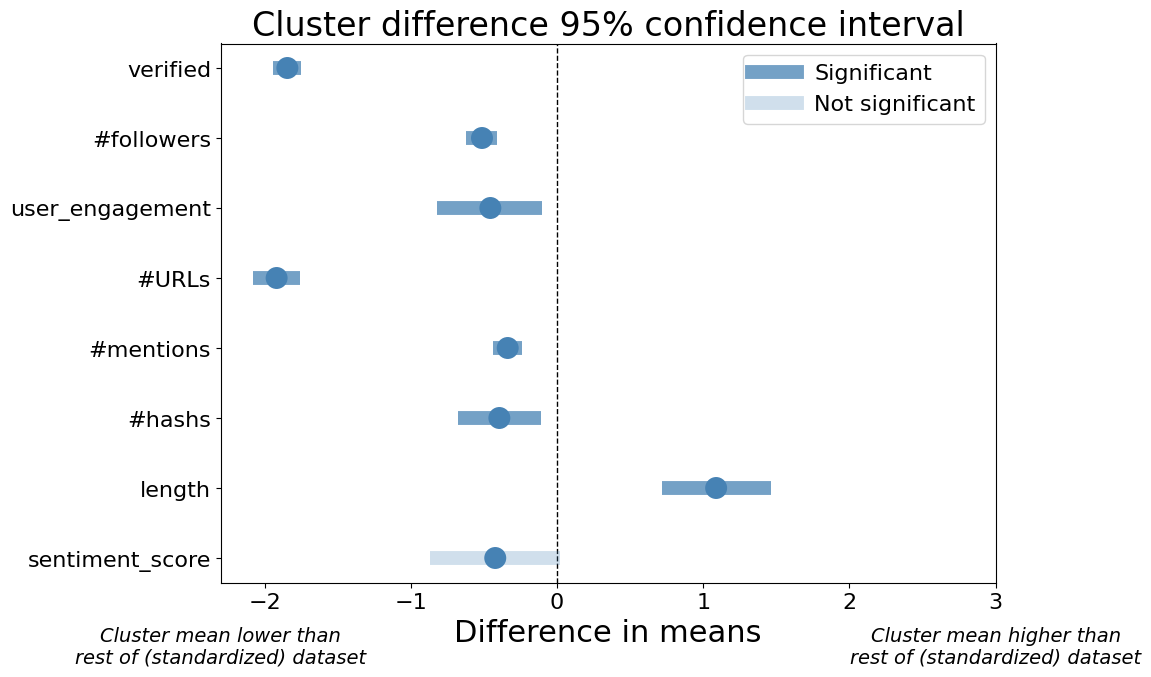

In [22]:
feat_ls = ['verified', '#followers', 'user_engagement', '#URLs', '#mentions', '#hashs', 'length', 'sentiment_score']
CI_plot(cluster_analysis_FP, x_lim=[-2.3,3], feat_ls=feat_ls)

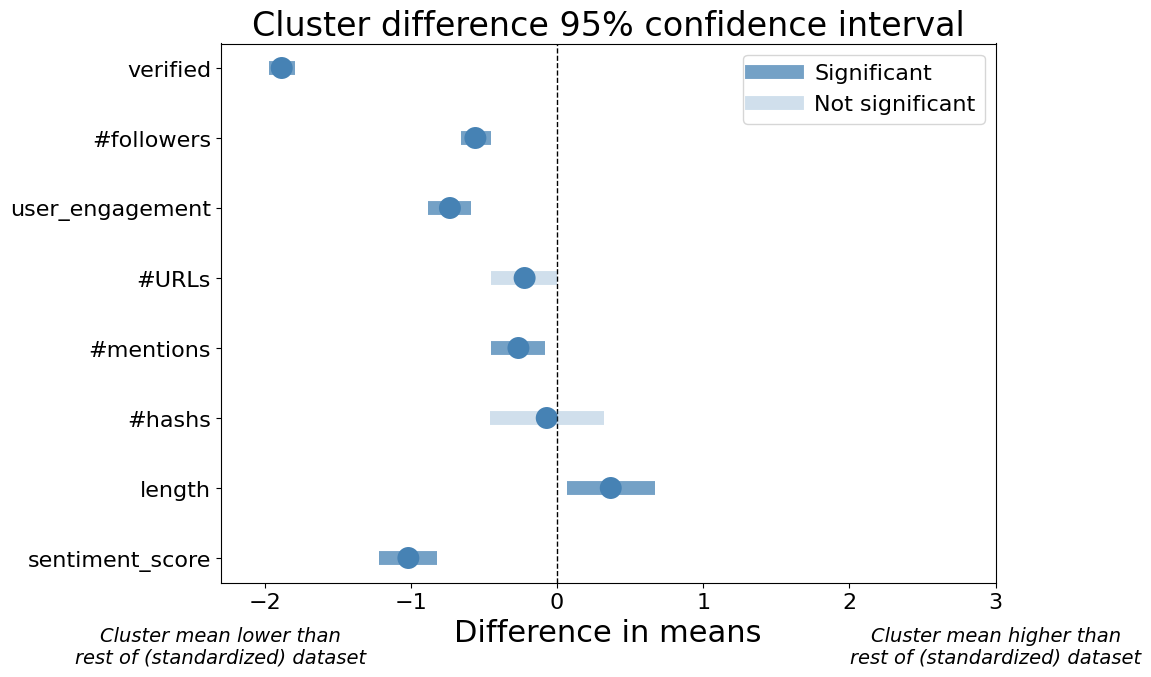

In [23]:
CI_plot(cluster_analysis_FN, x_lim=[-2.3,3], feat_ls=feat_ls)

#### Conclusion
On average, users that:
- are verified, have higher #followers, user engagement and #URLs;
- use less #hashags and have lower tweet length
have more true content classified as false (false positives).

On average, users that:
- use more #hashtags and have higher sentiment score;
- are non-verified, have less #followers, user engagement and tweet length
have more false content classified as true (false negatives).

\* The sentiment score is computed based on the [VADER python library](https://github.com/cjhutto/vaderSentiment#about-the-scoring). 

#### What's next?
Qualitative assessment with the help of subject matter experts to verify the measured quantitaive disparities. Additionally, sensitivity testing would be beneficial to shed light into the robustness of the bias scan tool. 